In [1]:
import pandas as pd
import itertools
from pygeodesy.sphericalNvector import LatLon
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
nm2m = 1852
m2nm = 0.000539957
ft2m = 0.3048
m2ft = 3.28084

def los(callsign0, callsign1, all_tracks, distance=False):
    track0 = all_tracks[all_tracks.CallSign==callsign0]
    track1 = all_tracks[all_tracks.CallSign==callsign1]
    location0 = [LatLon(lat, lon) for lat, lon in zip(track0.Latitude, track0.Longitude)]
    location1 = [LatLon(lat, lon) for lat, lon in zip(track1.Latitude, track1.Longitude)]
    h_distances = [p0.distanceTo(p1)*m2nm for p0, p1 in zip(location0, location1)]
    v_distances = [abs(h0-h1)*m2ft for h0, h1 in zip(track0.Height, track1.Height)]
    check = [ h_dist < 5. and v_dist < 1000. for h_dist, v_dist in zip(h_distances, v_distances)]
    if distance:
        idx = h_distances.index(min(h_distances))
        return min(h_distances), v_distances[idx], track0.ExerciseTime.values[idx]
    return any(check)


# function to plot all tracks
def plot_tracks(tracks, callsigns):
    plt.figure(figsize=(15,10))
    for cs in callsigns:
        track = tracks[tracks.CallSign==cs]
        plt.plot(track.Longitude, track.Latitude)
        plt.scatter(track.Longitude.values[0], track.Latitude.values[0])
        plt.axis('equal')

In [3]:
# import all tracks
all_tracks = pd.read_csv("data/tut/tutorial_full_tracks.csv")
all_tracks

,CallSign,ExerciseTime,Latitude,Longitude,Height
0,SIA865,0,2.5000,102.1874,10668.0
1,SIA367,0,2.5416,102.0376,9448.8
2,SIA489,0,2.5575,102.3020,9448.8
3,SIA992,0,3.1453,102.3973,11887.2
4,SIA311,0,3.1088,102.1609,11887.2
...,...,...,...,...,...
9615,SIA311,480,2.6554,101.9587,11887.2
9616,SIA992,480,2.8535,101.9952,11887.2
9617,SIA489,480,2.7314,101.8236,9448.8
9618,SIA524,480,2.9237,102.9609,11887.2


In [4]:
# list of all callsigns
callsigns = all_tracks.CallSign.unique()
assert len(callsigns)==20
# list of all ac pairs (2-element combinations)
pairs = []
for ownship, intruder in itertools.combinations(callsigns, r=2):
    pairs.append([ownship, intruder])

In [5]:
# find the pair that has LOS
check_los = Parallel(n_jobs=16)(delayed(los)(pair[0], pair[1], all_tracks) for pair in pairs)
los_index = [i for i in range(0, len(check_los)) if check_los[i]==True]

In [6]:
# show conflict pair (should be only one identical to ownship and intruder callsigns)
for index in los_index:
    # los_pair is the list 2 callsigns involved in the LOS (should be 'SIA865', 'SIA395')
    los_pair = pairs[index]
    print(pairs[index])

['SIA865', 'SIA395']


In [7]:
# CPA distance in nautical miles (lateral) and meter (vertical)
cpa_distances = los(*los_pair, all_tracks, distance=True)
cpa_distances

(4.097210311967638, 0.0, 299)

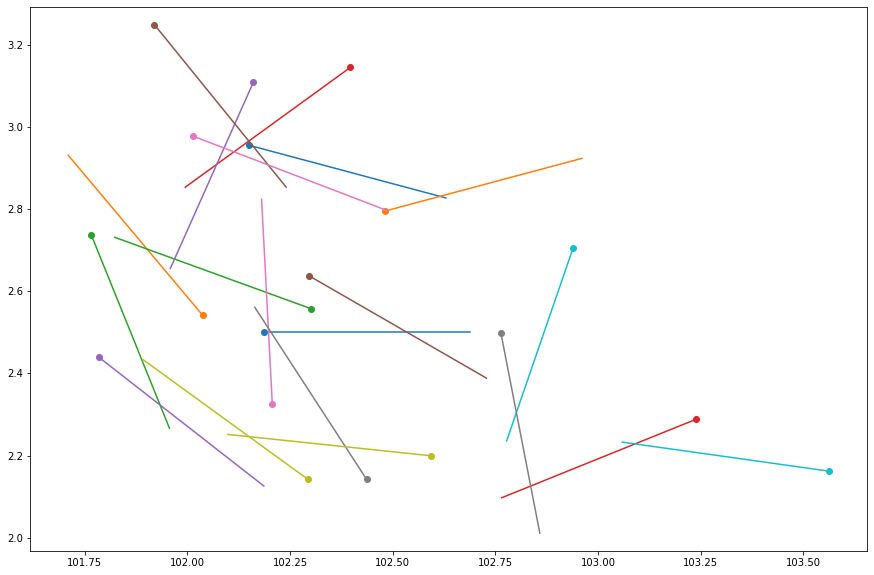

In [8]:
plot_tracks(all_tracks, callsigns)